## OpenAI Gym Warm-Up

In [59]:
# Import Environment class and Libraries
from frozen_lake import FrozenLakeEnv
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

# Create Environment Object
env = FrozenLakeEnv(map_name ="4x4", is_slippery=False)

# Access the number of states:
nS = env.observation_space
print("State space of the Env: ", nS)

# or you could even use 
nS = env.nS
print("State space of the Env by accessing env.nS: ", nS)

# Action space of the agent:
nA = env.nA
print("Action space of the Env: ", nA)

State space of the Env:  16
State space of the Env by accessing env.nS:  16
Action space of the Env:  4


In [60]:
"""
For policy iteration, you would need to access
State(s), Action(a), Next State(ns), Reward(r), episode ended? (is_done) tuples.
Note that in this environment, the orientation of the agent does not matter.
No matter what direction the agent is facing, if, say a left action is performed, 
the agent moves to the left of the crrent state.
"""
# For actions, this is the corresponding dictionary:
action_names = {0:'L', 1:'D', 2:"R", 3:"U"}

"""
Here, 
'L' means left
'D' means down
'R' means right
'U' means up

You can access these tuples by simply env.P[s][a].
where 's' is state, and 'a' is action. For example, let's say we are at state '4',
and we take an action '1' or "Down". The next state (ns) would be 8, the episode would not have ended (is_done), 
the reward (r) is 0 and the transition probabilty (prob) is 1 because this is a deterministic setting.
"""
prob, ns, r, is_done = env.P[4][1][0]

print("Transition Probabilty: ", prob)
print("Next State: ", ns)
print("Reward: ", r)
print("Episode ended? : ", is_done)
# Note that we need to add a [0] after env.P[s][a] because it returns a list containing the tuple

Transition Probabilty:  1.0
Next State:  8
Reward:  0.0
Episode ended? :  False


## Policy Iteration 

- Follow the pseudo-code given in the handout for this section

In [61]:
def print_policy(policy, action_names, states):
    """Print the policy in human-readable format.
    If you've implemented this correctly, the output (for 4x4 map) should be:
    
    D R D L 
    D L D L 
    R D D L 
    L R R L 
    
    Parameters
    ----------
    policy: np.ndarray
        Array of state to action number mappings
    action_names: dict
        Mapping of action numbers to characters representing the action.
    num_states: int
        Number of states in the FrozenLakeEnvironment (16 or 64 for 4x4 or 8x8 maps respectively)      
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)
    a=np.array(str_policy)
    if states==16:
        a=a.reshape((4,4))
    else:
        a=a.reshape((8,8))
   
    print(a)        
    
    pass
        

In [62]:
def evaluate_policy_sync(env, gamma, policy, value_func, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.
    
    Evaluates the value of a given policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    value_func: np.array
      Array of scalar values for each state
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    val_iter=0
    delta=np.zeros(env.nS)
    new_value_func=np.zeros(env.nS)
    for i in range(max_iterations):
        val_iter+=1
        temp=[]
        for j in range(env.nS):
            new_value_func[j]=value_func[env.P[j][policy[j]][0][1]]*gamma+env.P[j][policy[j]][0][2]
            delta[j]=max(delta[j],np.abs(new_value_func[j]-value_func[j]))
        if(delta.all()<tol):
            break;
            
    return new_value_func, val_iter

In [63]:
def improve_policy(env, gamma, value_func, policy):
    """Performs policy improvement.
    
    Given a policy and value function, improves the policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.

    Returns
    -------
    bool, np.ndarray
      Returns the new imporved policy.
    """
    new_policy=np.zeros(env.nS)
    for i in range(env.nS):
        action_list=[]
        for k in range(env.nA):
            temp=(env.P[i][k][0][2]+ gamma*value_func[env.P[i][k][0][1]])
            action_list.append(temp)
        new_policy[i]=np.argmax(np.array(action_list))

    return new_policy

In [64]:
def policy_iteration_sync(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    See page 85 of the Sutton & Barto Second Edition book.

    You should call the improve_policy() and evaluate_policy_sync() methods to
    implement this method.
    
    If you've implemented this correctly, it should take much less than 1 second.
    
    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    
    policy = np.random.randint(0, 4, size=env.nS)   #Define random policy
    value_func = np.zeros(env.nS)    # Define initial value function
    num_pol_iter = 0
    num_val_iter = 0
    value_func_list=[]
    
    # WRITE YOUR CODE HERE:
    policy_stable=False
    while policy_stable==False:
        num_pol_iter+=1
        new_value_func,num_val=evaluate_policy_sync(env,gamma,policy,value_func,max_iterations=int(1e3),tol=1e-3)
        num_val_iter+=num_val
        value_func=new_value_func
        new_policy=improve_policy(env,gamma,value_func,policy)
        value_func_list.append(value_func)
        temp=[]
        for i in range(env.nS):
            if(new_policy[i]==policy[i]):
                temp.append(1)
        policy=new_policy
        if(np.sum(np.array(temp))==env.nS):
            policy_stable=True
        else:
            policy_stable=False    

    return policy, value_func, num_pol_iter, num_val_iter,value_func_list

# Environment:4x4

[['D' 'R' 'D' 'L']
 ['D' 'L' 'D' 'L']
 ['R' 'D' 'D' 'L']
 ['L' 'R' 'R' 'L']]
Time taken by 4X4 environment is  0.0019953250885009766 seconds
Number of policy iterations is equal to 6
Number of value iterations is equal to 6


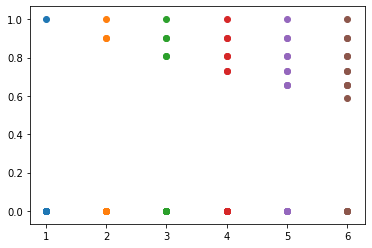

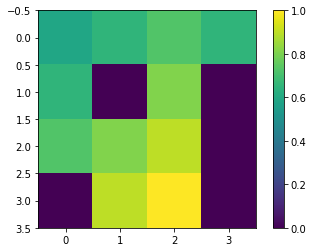

In [65]:
def main():
    
    start=time.time()
    env=FrozenLakeEnv(map_name='4x4',is_slippery=False)
    policy, value_func, num_pol_iter, num_val_iter, value_func_list=policy_iteration_sync(env,0.9,max_iterations=int(1e3),tol=1e-3) #Gamma is 0.9
    print_policy(policy,action_names,env.nS)
    end=time.time()
    print("Time taken by 4X4 environment is ",(end-start),"seconds")
    print("Number of policy iterations is equal to", num_pol_iter)
    print("Number of value iterations is equal to",num_val_iter)
    for i in range(num_pol_iter):
        plt.scatter(np.ones(env.nS)*(i+1),value_func_list[i])
    plt.show()
    plt.imshow(value_func.reshape(4,4))
    plt.colorbar()
    pass
    
    
if __name__ == "__main__":
    main()

# Environment:8x8

[['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'R' 'D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'L' 'D' 'R' 'D' 'D']
 ['R' 'R' 'R' 'R' 'D' 'L' 'D' 'D']
 ['R' 'R' 'U' 'L' 'D' 'D' 'R' 'D']
 ['D' 'L' 'L' 'R' 'R' 'D' 'L' 'D']
 ['D' 'L' 'R' 'U' 'L' 'D' 'L' 'D']
 ['R' 'R' 'U' 'L' 'R' 'R' 'R' 'L']]
Time taken by 8X8 environment is  0.012961149215698242 seconds
Number of policy iterations is equal to 14
Number of value iterations is equal to 14


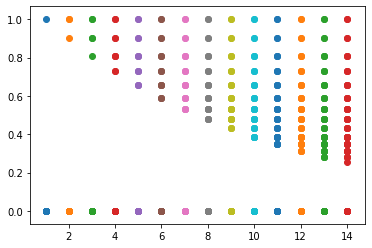

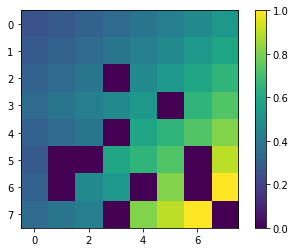

In [66]:
def main():
    
    start=time.time()
    env=FrozenLakeEnv(map_name='8x8',is_slippery=False)
    policy, value_func, num_pol_iter, num_val_iter, value_func_list=policy_iteration_sync(env,0.9,max_iterations=int(1e3),tol=1e-3) #Gamma is 0.9
    print_policy(policy,action_names,env.nS)
    end=time.time()
    print("Time taken by 8X8 environment is ",(end-start),"seconds")
    print("Number of policy iterations is equal to", num_pol_iter)
    print("Number of value iterations is equal to",num_val_iter)
    for i in range(num_pol_iter):
        plt.scatter(np.ones(env.nS)*(i+1),value_func_list[i])
    plt.show()
    plt.imshow(value_func.reshape(8,8))
    plt.colorbar()
    pass
    

if __name__ == "__main__":
    main()

# obseravtion for part B

- States closest to the target gets updated faster as the policy gets updated.As a result of which the frozen state closest to the target gets maximum value of the value function.
- Value function of the holes remain zero even after policy iteration.
- Value function of states are updated in decreasing order of their value.
- States with same value function are getting updated simultaneously.